# Tomato Disease Classification with InceptionV3 and Neural Network

# Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

**Citation** 
<br />
Huang, Mei-Ling; Chang, Ya-Han (2020), “Dataset of Tomato Leaves”, Mendeley Data, 
<br />
V1, doi: 10.17632/ngdgg79rzb.1

In [3]:
os.chdir("/kaggle/input/dataset-of-tomato-leaves/plant_village")
print(os.listdir())

TRAINING_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/train')
VALIDATION_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
TESTING_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/test')

['val', 'test', 'train']


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (299, 299)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 8715 files belonging to 10 classes.


2022-10-18 17:32:42.603003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 17:32:42.713593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 17:32:42.714659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 17:32:42.718462: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2902 files belonging to 10 classes.


In [7]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           shuffle=False,
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           image_size=IMG_SIZE)

Found 2914 files belonging to 10 classes.


In [8]:
class_names = train_dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'Two_spotted_spider_mite']

# Visualize Training Data for each Class

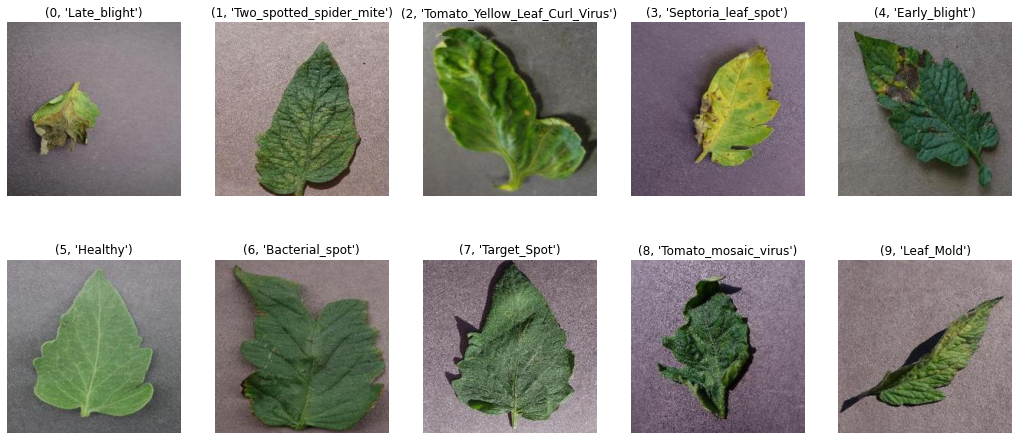

In [9]:
classes = os.listdir('./train')

plt.figure(figsize=(18,8))

for i in enumerate(classes):
    pic = os.listdir('./train/'+i[1])[0]
    image = Image.open('./train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2, 5, i[0]+1)
    plt.title(i)
    plt.imshow(image)
    plt.axis("off")
plt.show()

# Data Summary

In [10]:
categories = []
train = []
val = []
test = []

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/train', f))))

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
for f in folders:
    val.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/val', f))))

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
for f in folders:
    test.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/test', f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'val': val,
                     'test': test                     
                    })

data_count

,categories,train,val,test
0,Late_blight,916,305,307
1,Two_spotted_spider_mite,804,268,269
2,Tomato_Yellow_Leaf_Curl_Virus,2571,857,858
3,Septoria_leaf_spot,850,283,284
4,Early_blight,480,160,160
5,Healthy,763,254,255
6,Bacterial_spot,1021,340,341
7,Target_Spot,674,224,226
8,Tomato_mosaic_virus,179,59,61
9,Leaf_Mold,457,152,153


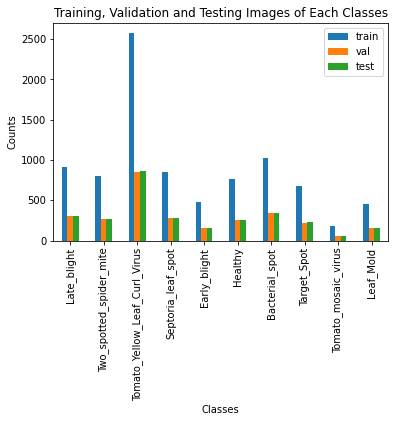

In [11]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

In [12]:
# Configure the dataset for performance
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [13]:
def data_augmentation(x):
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(factor=0.2),
    ])(x)

2022-10-18 17:32:48.403426: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


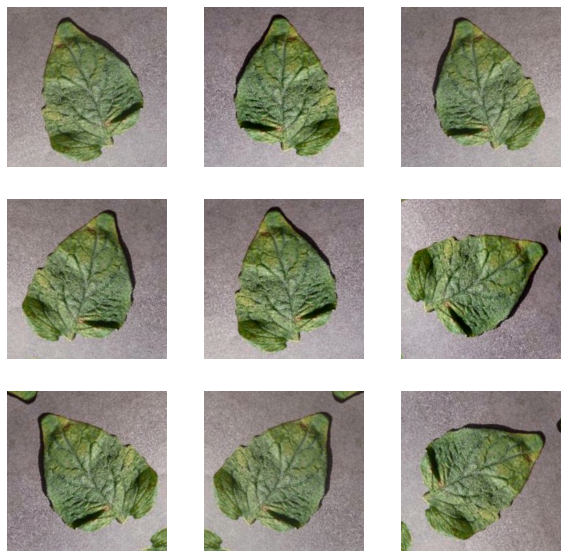

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Feature Extractor Base

In [15]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [16]:
base_model.trainable = False

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Utility Functions

In [17]:
def preprocess_input(x): 
    return tf.keras.layers.Rescaling(1./255, offset=-1)(x)


def feature_extractor(x):
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    return x


def classifier(x):
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x


def prediction_layer(x):
    return tf.keras.layers.Dense(10, activation='softmax')(x)

# Add Classification Head

In [18]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_extractor(x)
x = classifier(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

# Compile the Model

In [19]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

# Add CSV Logger

In [21]:
os.chdir("/kaggle/working")

log_csv = CSVLogger('./inceptionV3_NN_logs1.csv', separator=',', append=False)

In [22]:
initial_epochs = 10

In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[log_csv])

Epoch 1/10


2022-10-18 17:33:03.361098: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


273/273 [==============================] - 69s 206ms/step - loss: 1.5316 - accuracy: 0.4896 - val_loss: 1.0967 - val_accuracy: 0.6365
Epoch 2/10
273/273 [==============================] - 40s 146ms/step - loss: 1.0674 - accuracy: 0.6388 - val_loss: 0.9004 - val_accuracy: 0.6695
Epoch 3/10
273/273 [==============================] - 37s 132ms/step - loss: 0.8583 - accuracy: 0.7073 - val_loss: 0.7053 - val_accuracy: 0.7578
Epoch 4/10
273/273 [==============================] - 37s 133ms/step - loss: 0.7583 - accuracy: 0.7408 - val_loss: 0.6428 - val_accuracy: 0.7901
Epoch 5/10
273/273 [==============================] - 36s 130ms/step - loss: 0.6700 - accuracy: 0.7720 - val_loss: 0.5570 - val_accuracy: 0.8112
Epoch 6/10
273/273 [==============================] - 37s 133ms/step - loss: 0.6449 - accuracy: 0.7823 - val_loss: 0.5153 - val_accuracy: 0.8312
Epoch 7/10
273/273 [==============================] - 37s 134ms/step - loss: 0.6012 - accuracy: 0.7928 - val_loss: 0.5163 - val_accuracy: 0.8

# Plot Learning Curves

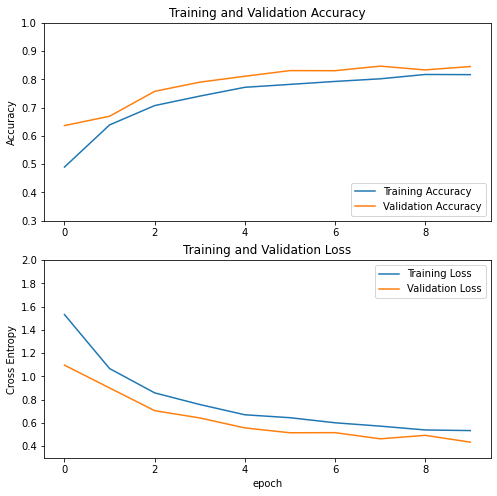

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.3,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.3,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Unfreeeze Some Layers of Feature Extractor

In [25]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 250

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


# Compile the Model

In [26]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

# Add Callbacks

In [28]:
checkpoint = ModelCheckpoint('./inceptionV3_NN.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
log_csv = CSVLogger('./inceptionV3_NN_logs2.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

# Continue Model Training

In [29]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callbacks_list)

Epoch 10/110
273/273 [==============================] - 51s 158ms/step - loss: 0.4424 - accuracy: 0.8528 - val_loss: 0.3220 - val_accuracy: 0.8935

Epoch 00010: val_loss improved from inf to 0.32200, saving model to ./inceptionV3_NN.hdf5
Epoch 11/110
273/273 [==============================] - 42s 152ms/step - loss: 0.3691 - accuracy: 0.8765 - val_loss: 0.2847 - val_accuracy: 0.9039

Epoch 00011: val_loss improved from 0.32200 to 0.28467, saving model to ./inceptionV3_NN.hdf5
Epoch 12/110
273/273 [==============================] - 43s 153ms/step - loss: 0.3137 - accuracy: 0.8935 - val_loss: 0.2721 - val_accuracy: 0.9083

Epoch 00012: val_loss improved from 0.28467 to 0.27208, saving model to ./inceptionV3_NN.hdf5
Epoch 13/110
273/273 [==============================] - 42s 151ms/step - loss: 0.2773 - accuracy: 0.9096 - val_loss: 0.2217 - val_accuracy: 0.9294

Epoch 00013: val_loss improved from 0.27208 to 0.22173, saving model to ./inceptionV3_NN.hdf5
Epoch 14/110
273/273 [==============

# Plot Learning Curve 

In [30]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

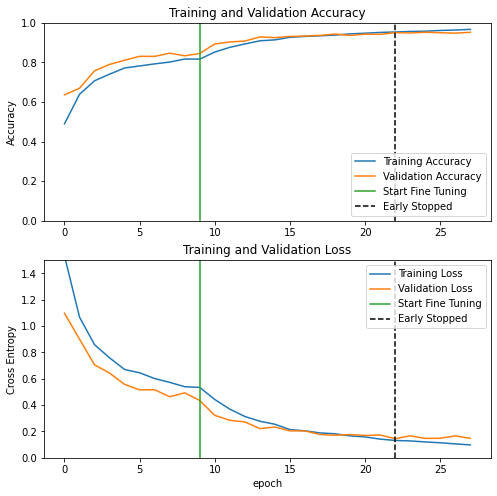

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

In [32]:
os.chdir("/kaggle/input/dataset-of-tomato-leaves/plant_village")

CLASSES = []

folders = os.listdir(TESTING_DIR)
for f in folders:
    CLASSES.append(f)
    
CLASSES

['Late_blight',
 'Two_spotted_spider_mite',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Septoria_leaf_spot',
 'Early_blight',
 'Healthy',
 'Bacterial_spot',
 'Target_Spot',
 'Tomato_mosaic_virus',
 'Leaf_Mold']

# Prediction and Evaluation

In [33]:
predictions = np.array([])
labels =  np.array([])

for x, y in test_dataset:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

Evaluating the Algorithm

Accuracy: 		 0.9557309540150996
Precision: 		 0.956603317187145
Recall: 		 0.9557309540150996
F1 score: 		 0.9557309540150996 



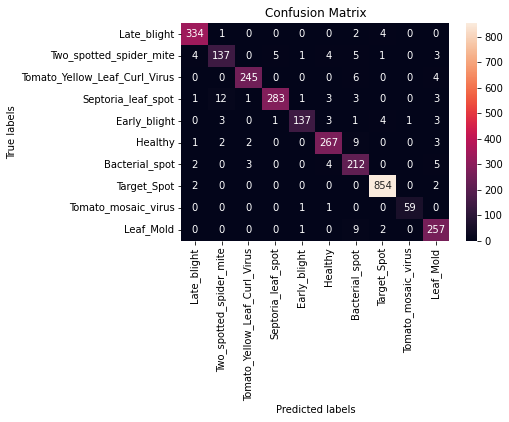

In [34]:
print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(labels, predictions))
print('Precision: \t\t', precision_score(labels, predictions, average='weighted'))
print('Recall: \t\t', recall_score(labels, predictions, average='weighted'))
print('F1 score: \t\t', f1_score(labels, predictions, average='micro'), '\n')

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);

ax.set_title('Confusion Matrix'); 

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.xaxis.set_ticklabels(CLASSES); 
ax.yaxis.set_ticklabels(CLASSES);

plt.xticks(rotation = 90)
plt.yticks(rotation = 360)

plt.show()